In [1]:
import numpy as np
import sys 

sys.path.append("C:/Users/guill/Documents/info MVA/info MVA/TD - TS/final project/DAD_library/BenchMark")

from MarkovianTechniques import FixedMarkovianBased
from BenchMark import MarkovianBenchMark

2
Model : <class 'MarkovianTechniques.FixedMarkovianBased.FixedMarkovianBased'>
precision : 0.31857142857142856
recall : 0.446
accuracy : 0.246
f1 : 0.37166666666666665
Model : <class 'MarkovianTechniques.FixedMarkovianBased.FixedMarkovianBased'>
precision : 0.08365019011406843
recall : 0.088
accuracy : 0.062
f1 : 0.08576998050682261
Model : <class 'MarkovianTechniques.FixedMarkovianBased.FixedMarkovianBased'>
precision : 0.1518987341772152
recall : 0.168
accuracy : 0.115
f1 : 0.15954415954415954
Model : <class 'MarkovianTechniques.FixedMarkovianBased.FixedMarkovianBased'>
precision : 0.3370165745856354
recall : 0.488
accuracy : 0.264
f1 : 0.39869281045751637


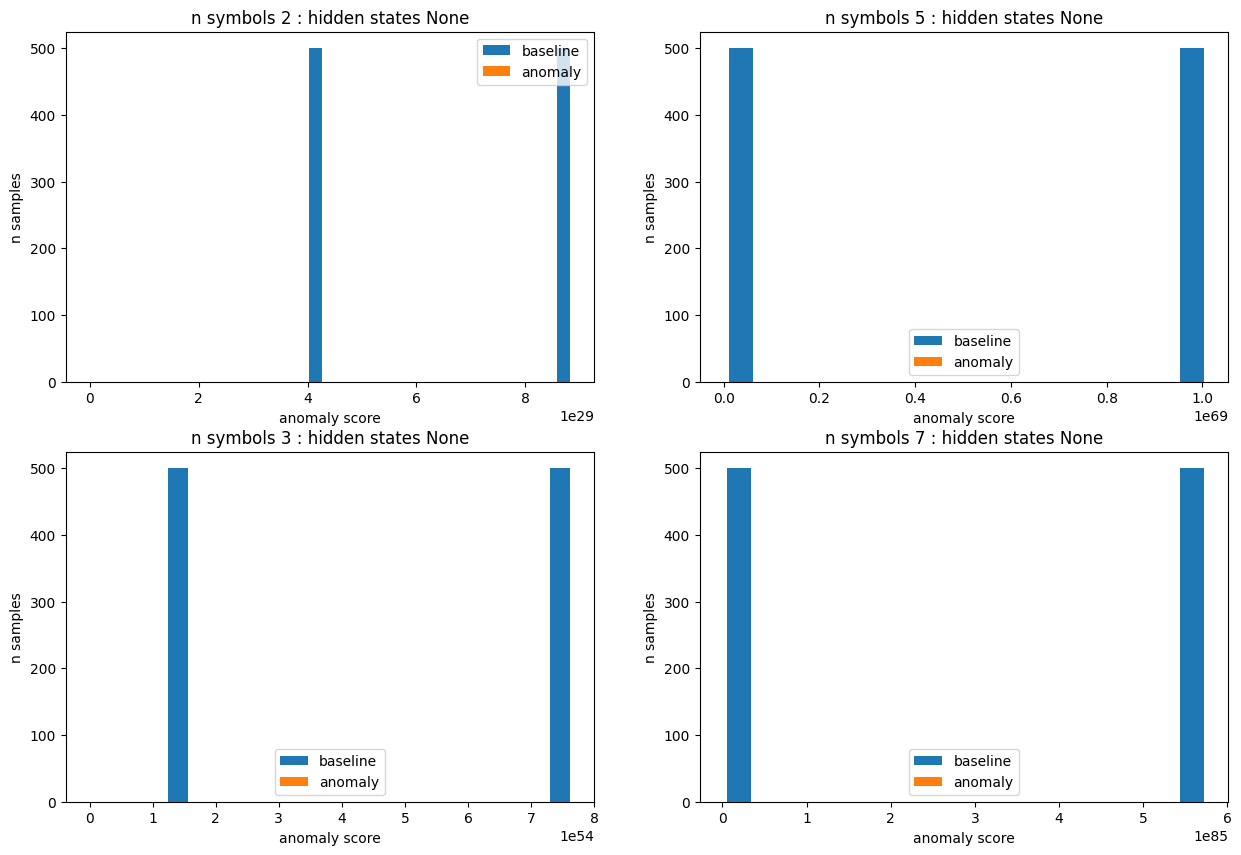

In [2]:
model = FixedMarkovianBased(max_depth=1)

n_symbols = [2, 3, 5, 7]
n_states = [None for _ in range(len(n_symbols))]

benchmark = MarkovianBenchMark(model, 
                               n_symbols_list=n_symbols, 
                               n_states_list=n_states,
                               dataset_size=1000, 
                               sequence_length=100,
                               )
benchmark.benchmark()